# Open and visualise modis l3 data

* you can get the files from https://oceancolor.gsfc.nasa.gov/l3/
* select what you want (details below)
* put in datasets dir

## imports

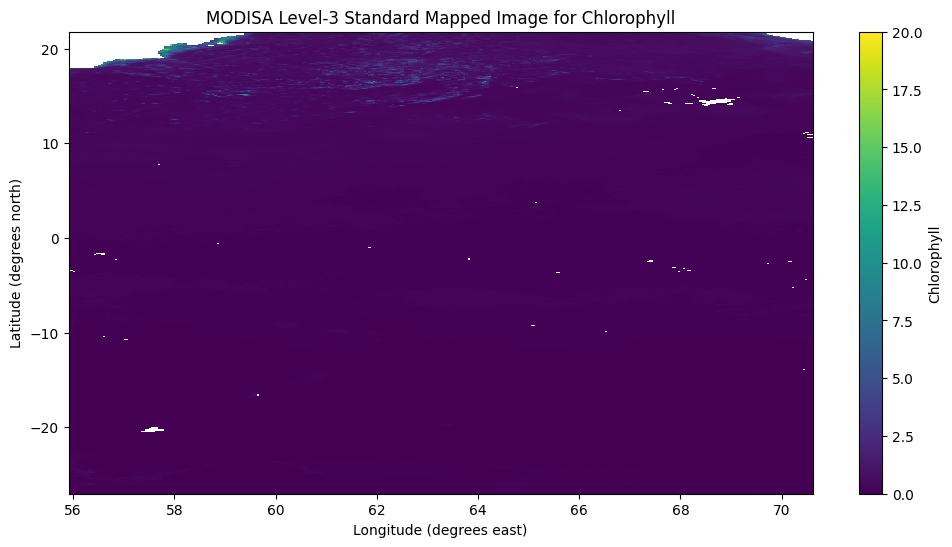

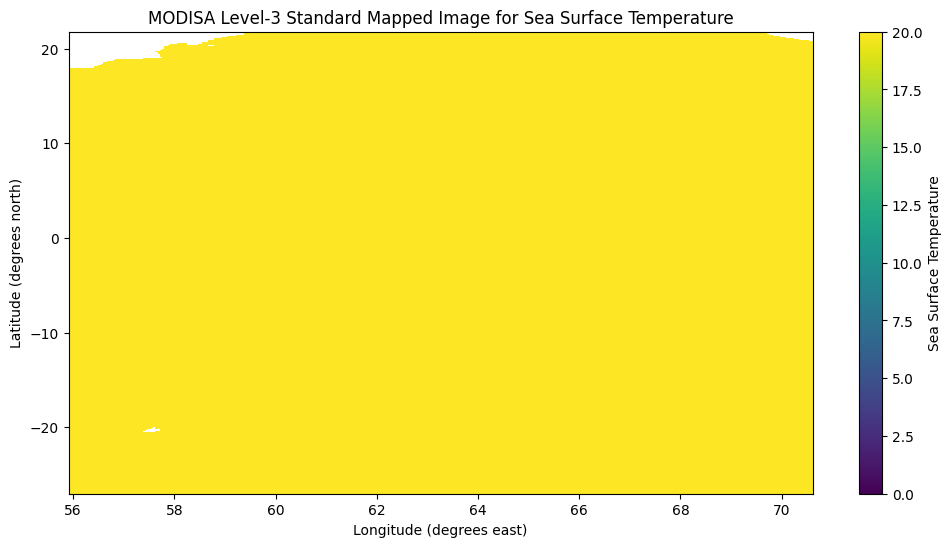

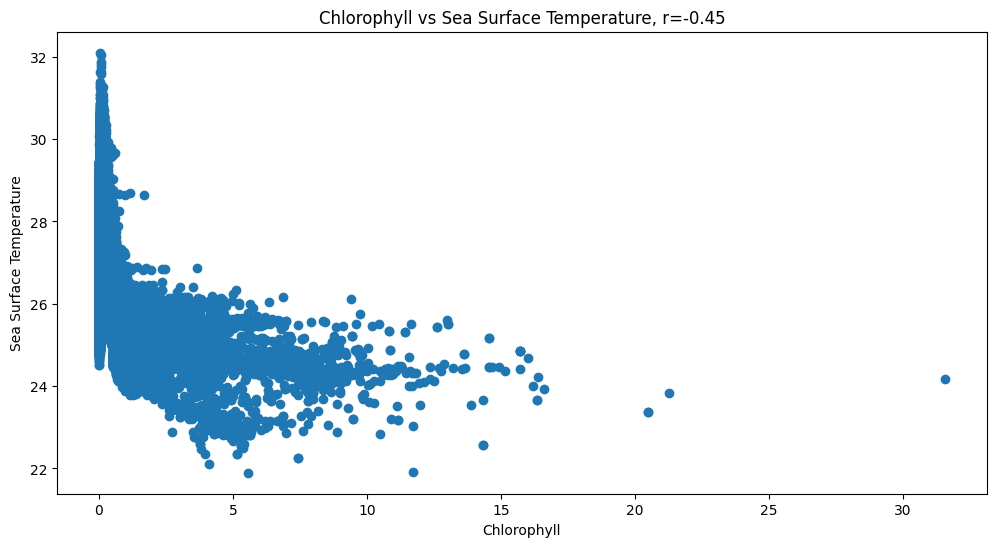

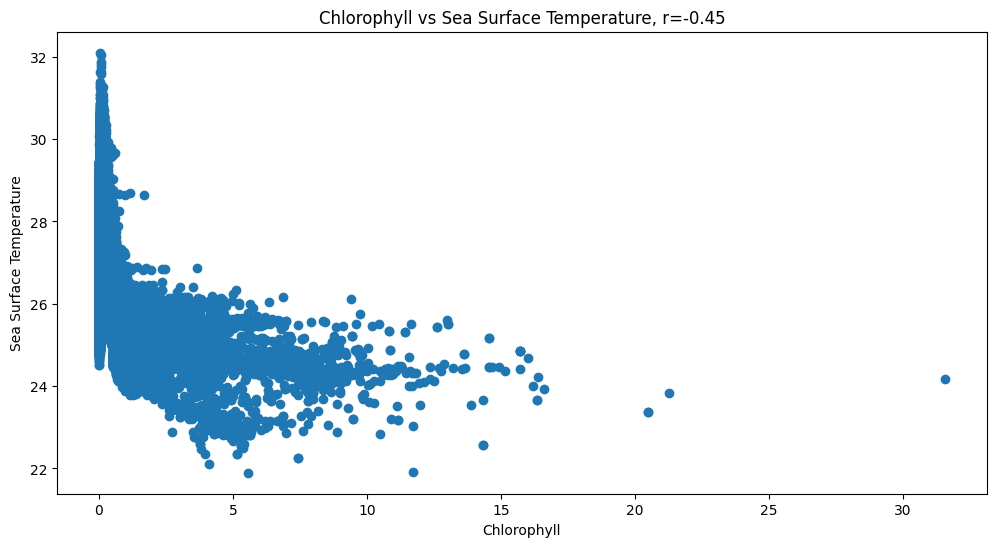

In [57]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# read the GeoJSON file
geojson_file = '../../datasets/modis/map.geojson'  # replace with your GeoJSON file path
gdf = gpd.read_file(geojson_file)
# to zoom into the region covered by the GeoJSON file
x_min, y_min, x_max, y_max = gdf.total_bounds

# to get this data, go to https://oceancolor.gsfc.nasa.gov/l3/order/
# select monthly data, 4km resolution, and the mapped option
# then select the data and time range you want

# possible modes: 
modes = [
    { # 0
      "type": "chlor_a", 
      "filename": "../../datasets/modis/AQUA_MODIS.20230101_20230131.L3m.MO.CHL.chlor_a.4km.nc",
      "description": "Chlorophyll"
    },
    { # 1
      "type": "sst",
      "filename": "../../datasets/modis/AQUA_MODIS.20230101_20230131.L3m.MO.SST.sst.4km.nc",
      "description": "Sea Surface Temperature"
    },
    # { # 2
    #   "type": "poc",
    #   "filename": "../../datasets/modis/AQUA_MODIS.20230101.L3m.DAY.POC.poc.4km.nc",
    #   "description": "Particulate Organic Carbon"
    # }
]

my_data_cropped_list = []

for mode in modes:
  # read the data
  data = nc.Dataset(mode["filename"], "r")

  # read latitude, longitude and poc data
  latitude = data.variables['lat'][:]
  longitude = data.variables['lon'][:]
  my_data = data.variables[mode["type"]][:]

  # replace fill values with NaN for better plotting
  fill_value = data.variables[mode["type"]]._FillValue
  my_data = np.where(my_data == fill_value, np.nan, my_data)

  # set any data below 0 to np.nan
  my_data = np.where(my_data < 0, np.nan, my_data)

  my_data_cropped = my_data[(latitude >= y_min) & (latitude <= y_max), :]
  my_data_cropped = my_data_cropped[:, (longitude >= x_min) & (longitude <= x_max)]
  longitude_cropped = longitude[(longitude >= x_min) & (longitude <= x_max)]
  latitude_cropped = latitude[(latitude >= y_min) & (latitude <= y_max)]

  # plot data
  plt.figure(figsize=(12, 6))
  plt.pcolormesh(longitude, latitude, my_data)
  plt.colorbar(label=mode["description"])
  plt.xlabel('Longitude (degrees east)')
  plt.ylabel('Latitude (degrees north)')
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.clim(0, 20)
  plt.title(f'MODISA Level-3 Standard Mapped Image for {mode["description"]}')
  plt.show()
  plt.close()

  # append my_data_cropped to a list
  my_data_cropped_list.append(my_data_cropped)

# calculate the correlation coefficient between the two arrays in the list
# create a scatter plot of the data from the pixels in each array in the list
# remove NaN values from both arrays before calculating the correlation coefficient
not_nan_mask = ~np.isnan(my_data_cropped_list[0]) & ~np.isnan(my_data_cropped_list[1])
my_cc = np.corrcoef(my_data_cropped_list[0][not_nan_mask], my_data_cropped_list[1][not_nan_mask])[0, 1]

plt.figure(figsize=(12, 6))
plt.scatter(my_data_cropped_list[0][not_nan_mask], my_data_cropped_list[1][not_nan_mask])
plt.xlabel(modes[0]["description"])
plt.ylabel(modes[1]["description"])
plt.title(f'{modes[0]["description"]} vs {modes[1]["description"]}, r={my_cc:.2f}')
plt.show()
plt.close()

## process the chlorophyll data

In [ ]:
mode = modes[0]

# read the data
data = nc.Dataset(mode["filename"], "r")

## modify

In [ ]:
print("=== GLOBAL ATTRIBUTES ===")
for attr in data.ncattrs():
    print(f"{attr}: {data.getncattr(attr)}")

print("\n=== DIMENSIONS ===")
for dim, dim_info in data.dimensions.items():
    print(f"{dim}: {len(dim_info)}")

print("\n=== VARIABLES ===")
for var, var_info in data.variables.items():
    print(f"{var}: {var_info}")

print("\n=== GROUPS ===")
for group in data.groups:
    print(group)

# read latitude, longitude and poc data
latitude = data.variables['lat'][:]
longitude = data.variables['lon'][:]
my_data = data.variables[mode["type"]][:]

# replace fill values with NaN for better plotting
fill_value = data.variables[mode["type"]]._FillValue
my_data = np.where(my_data == fill_value, np.nan, my_data)

# # apply the scale_factor and add_offset
# scale_factor = data.variables['chlor_a'].scale_factor
# add_offset = data.variables['chlor_a'].add_offset
# poc_data = poc_data * scale_factor + add_offset

## crop by coordinates (doesn't work for christina)

In [ ]:
# read and plot the GeoJSON file
geojson_file = '../../datasets/modis/map.geojson'  # replace with your GeoJSON file path
gdf = gpd.read_file(geojson_file)

for polygon in gdf.geometry:
    x,y = polygon.exterior.xy
    plt.plot(x, y, color="red")  # adjust the color as you like

# to zoom into the region covered by the GeoJSON file
x_min, y_min, x_max, y_max = gdf.total_bounds

# set any data below 0 to np.nan
my_data = np.where(my_data < 0, np.nan, my_data)

# print the max and min values of my_poc_data
print(np.nanmax(my_data))
print('----')
print(np.nanmin(my_data))

In [ ]:
# standard values https://oceancolor.gsfc.nasa.gov/l3/:
  # POC: 10 - 1000 mg m^-3
  # SST: -10 - 50 C
  # chlor_a: 0.01 - 20 mg m^-3

# for each mode, crop out data outside of these ranges (which are land/sea not relevant)
if mode["type"] == "poc":
    my_poc_data = np.where(my_data < 10, np.nan, my_data)
    my_poc_data = np.where(my_data > 1000, np.nan, my_data)
elif mode["type"] == "sst":
    my_poc_data = np.where(my_data < -10, np.nan, my_data)
    my_poc_data = np.where(my_data > 50, np.nan, my_data)
elif mode["type"] == "chlor_a":
    my_poc_data = np.where(my_data < 0.01, np.nan, my_data)
    my_poc_data = np.where(my_data > 20, np.nan, my_data)

# visualisation

## chlorophyll

### save mapped image (chlor_a)

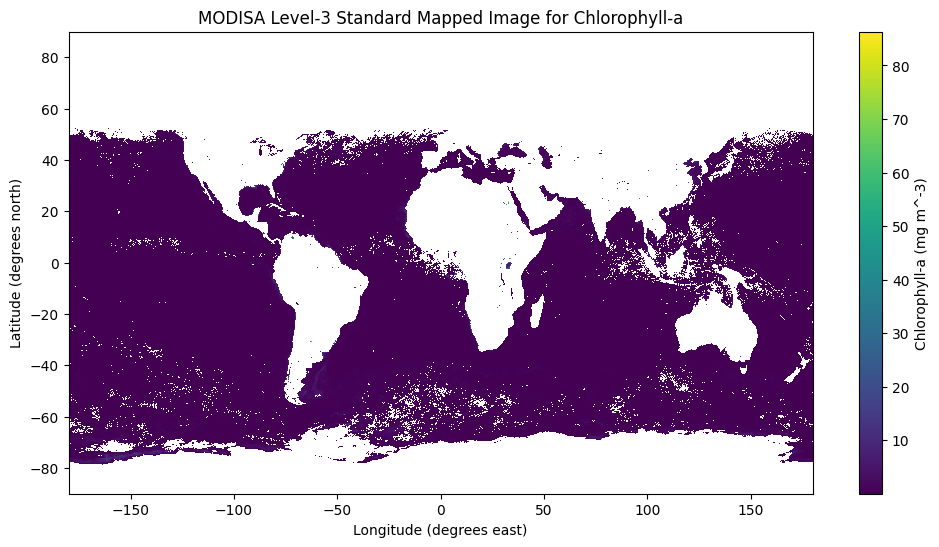

In [30]:
if mode["type"] == "chlor_a":
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(longitude, latitude, my_data)
    plt.colorbar(label='Chlorophyll-a (mg m^-3)')
    plt.xlabel('Longitude (degrees east)')
    plt.ylabel('Latitude (degrees north)')
    plt.title('MODISA Level-3 Standard Mapped Image for Chlorophyll-a')
    plt.show()

### save histogram (chlor_a)

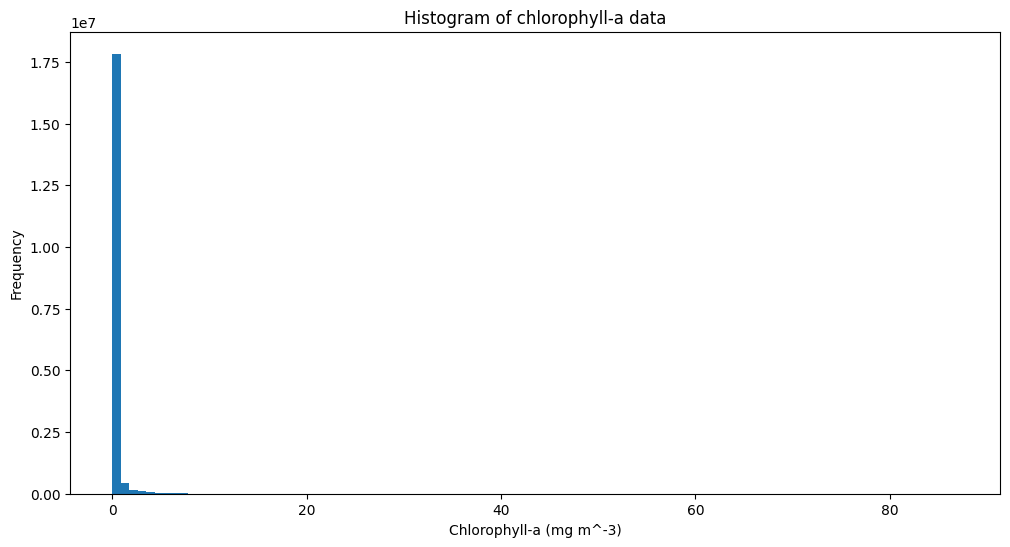

In [35]:
if mode["type"] == "chlor_a":
    # plot a histogram of the data excluding values below 1000
    plt.figure(figsize=(12, 6))
    plt.hist(my_data[~np.isnan(my_data)], bins=100, range=(0, 87))
    plt.xlabel('Chlorophyll-a (mg m^-3)')
    plt.ylabel('Frequency')
    plt.title('Histogram of chlorophyll-a data')
    plt.show()

### saved cropped image (chlor_a)

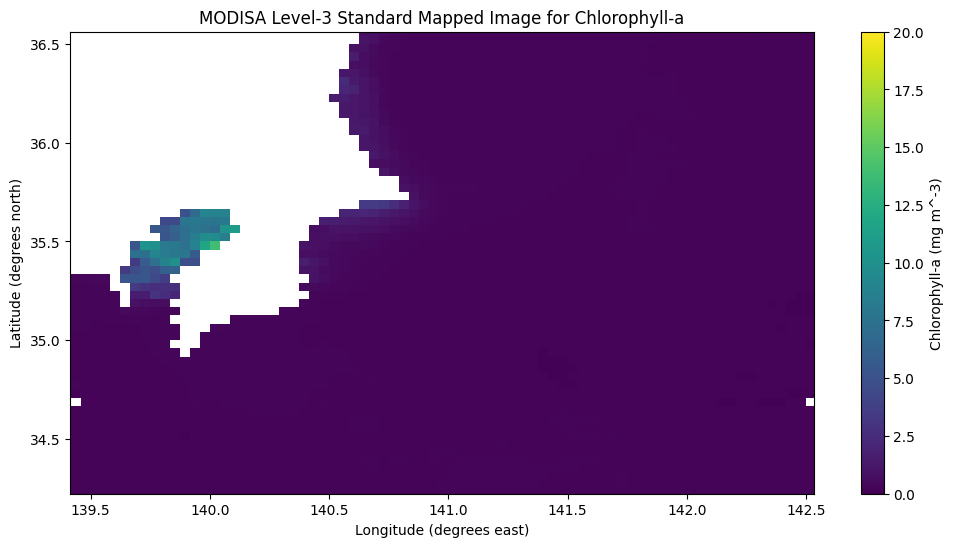

In [38]:
if mode["type"] == "chlor_a":

    # set min and max value
    min_value = 0
    max_value = 20

    # plot data
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(longitude, latitude, my_data)
    plt.colorbar(label='Chlorophyll-a (mg m^-3)')
    plt.xlabel('Longitude (degrees east)')
    plt.ylabel('Latitude (degrees north)')
    plt.title('MODISA Level-3 Standard Mapped Image for Chlorophyll-a')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.clim(min_value, max_value)
    plt.show()

## sea surface temperature

### save mapped image (sst)

In [ ]:
if mode["type"] == "sst":
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(longitude, latitude, data)
    plt.colorbar(label='Temperature')
    plt.xlabel('Longitude (degrees east)')
    plt.ylabel('Latitude (degrees north)')
    plt.title('MODISA Level-3 Standard Mapped Image for SST')
    plt.savefig('tmp/modis_sst.png')
    plt.close()

### save histogram (sst)

In [ ]:
if mode["type"] == "sst":
    # todo - does the range make sense??
    # plot a histogram of the data excluding values below 1000
    plt.figure(figsize=(12, 6))
    plt.hist(data[~np.isnan(data)], bins=100, range=(0, 87))
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Histogram of temperature data')
    plt.savefig('tmp/modis_sst_hist.png')
    plt.close()

### save cropped mapped image (sst)

In [ ]:
if mode["type"] == "sst":
    # set min and max value
    min_value = 0
    max_value = 20

    # plot data
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(longitude, latitude, data)
    plt.colorbar(label='Sea Surface Temperature')
    plt.xlabel('Longitude (degrees east)')
    plt.ylabel('Latitude (degrees north)')
    plt.title('MODISA Level-3 Standard Mapped Image for SST')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.clim(min_value, max_value)
    plt.savefig('tmp/modis_sst_crop.png')
    plt.close()

## particulate organic carbon

### save mapped image (poc)

In [ ]:
if mode["type"] == "poc":

    # apply the scale_factor and add_offset
    scale_factor = data.variables['poc'].scale_factor
    add_offset = data.variables['poc'].add_offset
    data = data * scale_factor + add_offset

    # plot data
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(longitude, latitude, data)
    plt.colorbar(label='Particulate Organic Carbon (mg m^-3)')
    plt.xlabel('Longitude (degrees east)')
    plt.ylabel('Latitude (degrees north)')
    plt.title('MODISA Level-3 Standard Mapped Image for POC')
    plt.savefig('modis_poc.png')
    plt.close()

### save cropped image (poc)

In [ ]:
if mode["type"] == "poc":

    # plot data
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(longitude, latitude, data)
    plt.colorbar(label='Particulate Organic Carbon (mg m^-3)')
    plt.xlabel('Longitude (degrees east)')
    plt.ylabel('Latitude (degrees north)')
    plt.title('MODISA Level-3 Standard Mapped Image for POC')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.savefig('modis_poc_crop.png')
    plt.close()